/Users/louisdavid/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


Number of features: 32
MAE (Training Set):  0.16003147290560726
RMSE (Training Set):  0.2045881927105376
r2 score (Training Set):  0.9647118953527549

MAE (Test Set):  0.2744207279638566
RMSE (Test Set):  0.3443337385041992
r2 score (Test Set):  0.8511111975759884
Cross Validation Values:  [0.91715943 0.71315514 0.86463656 0.56648056 0.58394744 0.90475147
 0.85587734]
Cross Validation Score:  0.7722868497064627
No calibration with n_samples <= 20:  consider using more n_estimators in your model,  for more accurate ci and to avoid negative values.


/Users/louisdavid/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in sqrt


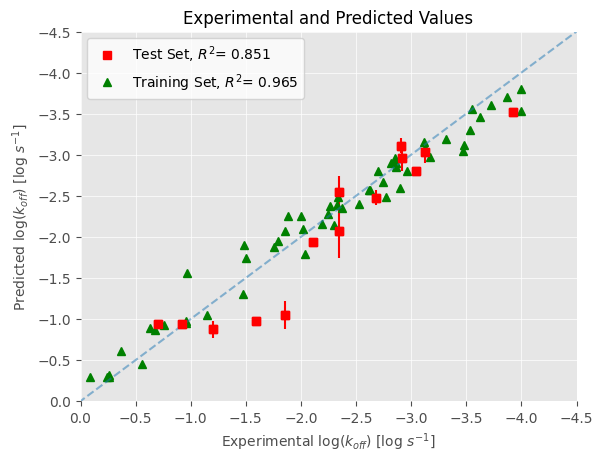

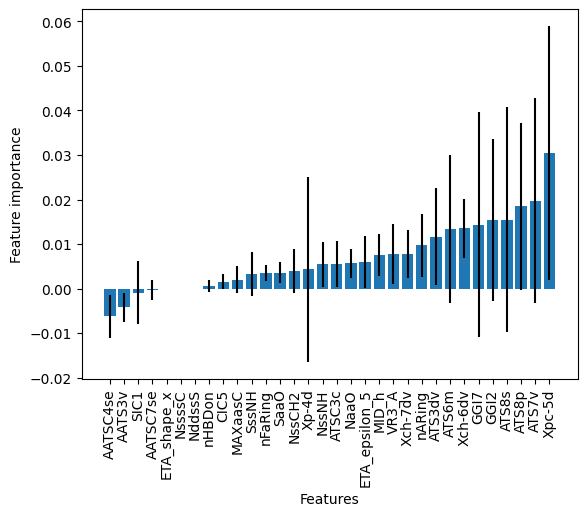

In [15]:
#Random Forest of Model, of which features were selected using the Variance and Feature Importance based Feature 
#Selection Method after subsequent Hyperparameter Optimization

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.feature_selection import VarianceThreshold
%matplotlib inline
import forestci as fci
from forestci import random_forest_error

#Features should be in the top row of csv file with one column being called 'K_off' being the label values
Features=['K_off','NssNH', 'nARing', 'SssNH', 'nFaRing', 'MID_h', 'NssCH2', 'Xch-6dv', 'NaaO', 'ATS8s', 'SaaO', 'GGI7', 'ETA_shape_x', 'Xch-7dv', 'ATS8p', 'MAXaasC', 'ATS7v', 'ETA_epsilon_5', 'Xp-4d', 'ATS6m', 'ATS3dv', 'GGI2', 'ATSC3c', 'NssssC', 'NddssS', 'AATSC7se', 'Xpc-5d', 'VR3_A', 'CIC5', 'nHBDon', 'SIC1', 'AATS3v', 'AATSC4se']

#Reading and processing of Features
data = pd.read_csv("HSP90_Mordred_Features.csv",';',low_memory=False,usecols=lambda x: x in Features)
features = pd.get_dummies(data)
labels = np.array(np.log10(features['K_off']))
features = features.drop('K_off', axis = 1)
feature_list = list(features.columns)
features = np.array(features)

#**************************************************************************************************
#Sorting Features by descending variance

variance_threshold=-1
#print(f'Variance threshold: {variance_threshold}')

Feat_var = {}
for x in range(len(features[0,:])):
    List_scal = []                 #scale all features between 0 and 1
    sort = sorted(features[:,x])
    mini = sort[0]
    maxi = sort[-1]
    for i in features[:,x]:
        i_scal = (i-mini)/(maxi-mini)
        List_scal.append(i_scal)
    mean = sum(List_scal)/len(List_scal)

    List_var = []
    for i in List_scal:
        var = ((i-mean)**2)/(len(List_scal)) #calculate variance of features
        List_var.append(var)
    variance = sum(List_var)
    List_features_dummy = []
    if variance>variance_threshold:
        for j in features[:,x]:
            List_features_dummy.append(j)
        Feat_var[feature_list[x],variance]=List_features_dummy

Feat_var2 = sorted(Feat_var, key=lambda x: x[1], reverse=True) #sort features by variance
feature_list = []
features = []

for x in Feat_var2:
    feature_list.append(x[0])
    features.append(Feat_var[x])
features = np.array(features).transpose()


#**************************************************************************************************

#Calculate correlations and delete features with correlation above correlation_threshold

correlation_threshold = 2.0 #No correlation thresholding for value higher than 1.0

#print(f'Correlation threshold: {correlation_threshold}')

#Calculation and deleting of correlated features
corr = np.corrcoef(features.transpose())
List_numbers = []
corrdict={}

for x in range(0,len(corr),1):
    for y in range(0,len(corr),1):
        if x!=y and abs(corr[x,y])>correlation_threshold:
            #print(f'{x},{y} : {corr[x,y]}')
            if (y,x) not in corrdict:
                corrdict[x,y]=1
                if y not in List_numbers:
                    List_numbers.append(y)
feature_list_dummy = []
features_dummy = []

for x in range(len(feature_list)):
    if x not in List_numbers:
        feature_list_dummy.append(feature_list[x])
        features_dummy.append(features[:,x])
feature_list = feature_list_dummy
features = np.array(features_dummy).transpose()

print(f'Number of features: {len(feature_list)}')
    
#**************************************************************************************************

#Splitting of Data
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, test_size = 0.20, random_state = 7)

        
#Random Forest Regressor
rf = RandomForestRegressor(
    n_estimators = 220, random_state = 7, max_depth = 6, max_features='log2') 
rf.fit(train_features, train_labels)
predictions_test = rf.predict(test_features)
predictions_train = rf.predict(train_features)

        
#Calculation of Metrics
mae_train = metrics.mean_absolute_error(train_labels, predictions_train)
mse_train = metrics.mean_squared_error(train_labels, predictions_train)
rmse_train = mse_train**0.5
r2_train = r2_score(train_labels, predictions_train)

mae_test = metrics.mean_absolute_error(test_labels, predictions_test)
mse_test = metrics.mean_squared_error(test_labels, predictions_test)
rmse_test = mse_test**0.5
r2_test = r2_score(test_labels, predictions_test)

print('MAE (Training Set): ',mae_train)
print('RMSE (Training Set): ',rmse_train)
print('r2 score (Training Set): ', r2_train)
print('')
print('MAE (Test Set): ',mae_test)
print('RMSE (Test Set): ',rmse_test)
print('r2 score (Test Set): ', r2_test)


#Calculation of Cross Validation Scores
n_scores = cross_val_score(rf, train_features, train_labels, cv=7, scoring='r2')
n_score = n_scores.mean()

print('Cross Validation Values: ',n_scores)
print('Cross Validation Score: ',n_score)



#******************************************************************************

#Plotting of Predictions

err = fci.random_forest_error(rf, train_features, test_features)
plt.errorbar(test_labels, predictions_test,  yerr=np.sqrt(err), fmt = 'rs')

ax = plt.axes()
ax.set_facecolor(color='0.9')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.title('Experimental and Predicted Values')
Legend_label = [f'Test Set, $R^{2}$= {round(r2_test,3)}',f'Training Set, $R^{2}$= {round(r2_train,3)}']
plt.ylabel('Predicted log($k_{off}$) [log $s^{-1}$]',color='0.3')
plt.xlabel('Experimental log($k_{off}$) [log $s^{-1}$]',color='0.3')
plt.plot(test_labels, predictions_test, 'rs')
plt.plot(train_labels, predictions_train, 'g^')
Listplotfit = [0.5, -4.5]
plt.plot(Listplotfit, Listplotfit, "--", alpha=0.5)
plt.grid(color='1.0', linestyle='-', linewidth=0.5)
ticklist=[0.5,0.0,-0.5,-1.0,-1.5,-2.0,-2.5,-3.0,-3.5,-4.0,-4.5]
plt.xticks(ticklist,color='0.3')
plt.tick_params(color='0.3')
plt.yticks(ticklist,color='0.3')
plt.ylim(ymin=0.0,ymax=-4.5)
plt.xlim(xmin=0.0,xmax=-4.5)
plt.legend(Legend_label)
plt.show()

#******************************************************************************


#Calculation of Feature Importances
result = permutation_importance(rf, test_features, test_labels, n_repeats=30, random_state=0)
forest_importances = pd.Series(result.importances_mean, index=feature_list)

#Sorting the Feature Importances by ascending Importance
imp_mean = list(result.importances_mean)
imp_std = list(result.importances_std)
resultdict={}
for x in range(len(a)):
    resultdict[feature_list[x]]= (imp_mean[x],imp_std[x])
    
sorted_dictionary=sorted(resultdict.items(), key=lambda x: x[1])
sorted_keys=[k for k, v in sorted_dictionary]
sorted_errors=[v[1] for k, v in sorted_dictionary]
sorted_importance=[v[0] for k, v in sorted_dictionary]
    
#Plotting the Importances
plt.xticks(rotation=90)
plt.bar(sorted_keys, sorted_importance, yerr=sorted_errors)
plt.xlabel('Features')
plt.ylabel('Feature importance')
plt.show()